In [ ]:
import os, sys
sys.path.append(os.path.abspath(".."))


In [17]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# The Premise

The example here is using a convolutional neural network to recognize `Fashion MNIST` samples, basically black and white 28 by 28 pixel images of clothing, with a label of what the clothing is

The Job of the network will be : when given an image sample, it will determine the type of clothe the image is representing

Here is the github for Fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

# New Libraries


1. `torchvision` - the base lib for cv with pytorch
2. `torchvision.datasets` - data loading functions, and pre made data sets
3. `torchvision.models` - loading pre trained cv models
4. `torchvision.transforms` - manipulating images
5. `torch.utils.data.Dataset` - base dataset for pytorch
6. `torch.utils.data.DataLoader` - iterating over samples of dataset

# The Data

## Getting Data

Getting the data from torchvision.datasets, and downloading them locally

In [18]:
train_data = torchvision.datasets.FashionMNIST(root="data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
test_data = torchvision.datasets.FashionMNIST(root="data", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

## Visualizing Data

For a random, singular image in the training data

Image shape: torch.Size([1, 28, 28]), Image label: Sneaker


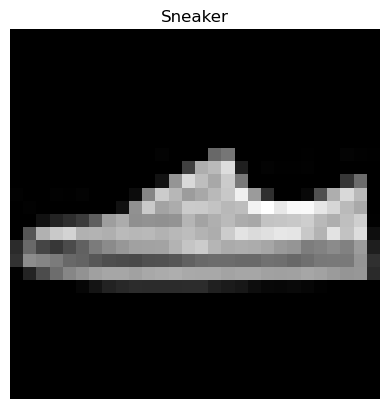

In [19]:
image, label = train_data[torch.randint(0, len(train_data), size=[1]).item()]
print(f"Image shape: {image.shape}, Image label: {train_data.classes[label]}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False);

For a random group of images in the training data

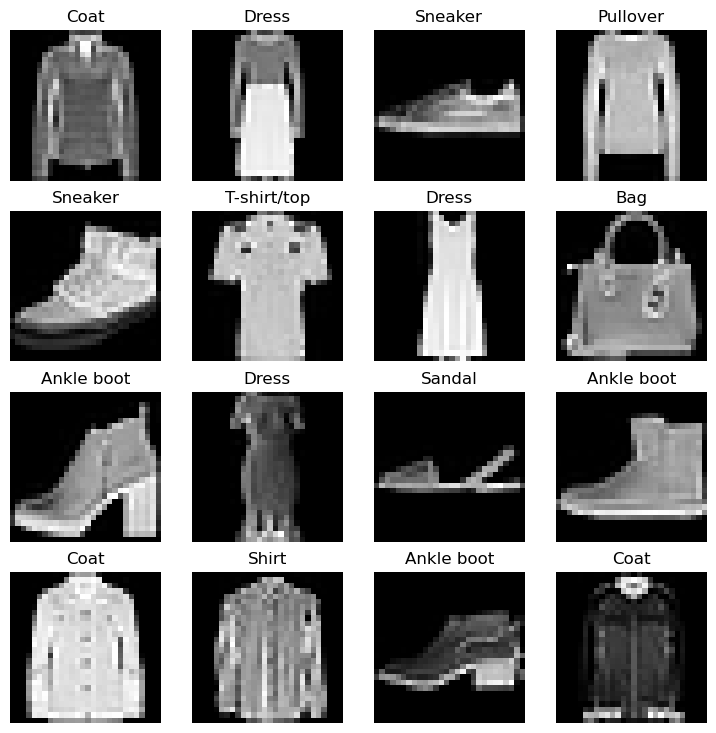

In [20]:
rows, cols = 4,4
figure = plt.figure(figsize=(9,9))
for i in range(1, rows*cols+1):

    image, label = train_data[torch.randint(0, len(train_data), size=[1]).item()]
    figure.add_subplot(rows, cols, i)
    
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)

## Formatting Data

using torch.utils.data.DataLoader, Creating Little batches of data (list of lists) for performing stochastic gradient descent

In [21]:
batch_size = 32
train_data_batch = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data_batch = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(f"Length of total training batches: {len(train_data_batch)}\nLength of total testing batches: {len(test_data_batch)}")

Length of total training batches: 1875
Length of total testing batches: 313


# Lv1 Network

## The Network

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
torch.manual_seed(42)

class FashionMNIST_Lv1(nn.Module):
    def __init__(self):
        super().__init__()

        #nn.Flatten basically turns the 28*28 2d array of the image, into a 1d array of 784 elements
        #now we will use a list to iterate through our layers, and activation functions in between
        self.layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=784, out_features=50),
            nn.LeakyReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.LeakyReLU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Softmax(dim=1))
        

    #wow! now this is so much more easier, how will I add activation function in between though?
    def forward(self, input):
        output = self.layers(input)
        return output
    
model_lv1 = FashionMNIST_Lv1().to(device)

Getting the helper_functions.py

In [24]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


Setup Loss Function, Optimizer, and Evaluation Metrics

1. Loss Function - `nn.CrossEntropyLoss()`
2. Optimizer - `torch.optim.SGD()`
3. Evaluation Metric - `Accuracy`, from the helper_functions.py

In [25]:
loss_fn = nn.CrossEntropyLoss()
optim_SGD = torch.optim.SGD(params=model_lv1.parameters(), lr=0.1)
from helper_functions import accuracy_fn

## The Training/Testing

In [26]:
#This guy creates a loading bar for our progress! That is really cool

from tqdm.auto import tqdm
torch.manual_seed(42)
epochs = 0


for epoch in tqdm(range(epochs)):
    
    #True SGD! The loss is initialized to 0 every epoch, and is accumulated by every mini-batch
    #Then the average training loss will come from total train_loss divided by number of mini batches
    total_train_loss = 0
    model_lv1.train()

    for image, label in train_data_batch:

        image, label = image.to(device), label.to(device)

        predictions = model_lv1(image)
        train_loss = loss_fn(predictions, label)
        total_train_loss += train_loss

        optim_SGD.zero_grad()
        train_loss.backward()
        optim_SGD.step()

    average_train_loss = train_loss / len(train_data_batch)


    test_accuracy = 0
    model_lv1.eval()

    for test_image, test_label in test_data_batch:

        image, label = image.to(device), label.to(device)

        test_predictions = model_lv1(test_image)
        test_loss = loss_fn(test_predictions, test_label)
        test_accuracy += accuracy_fn(test_label, test_predictions.argmax(dim=1))

        optim_SGD.zero_grad()
        test_loss.backward()
        optim_SGD.step()

    average_test_accuracy = test_accuracy / len(test_data_batch)

    
    print(f"Epoch {epoch} | Train Loss: {average_train_loss:.4f} | Test Accuracy: {average_test_accuracy:.2f}%")


0it [00:00, ?it/s]

# The Improving

Using `CNN` convolution neural networks, because they work the best with finding patterns in visual data

1. As for what a convolution is, here is a link https://www.youtube.com/watch?v=KuXjwB4LzSA
2. Here is why they work for image processing https://www.youtube.com/watch?v=8rrHTtUzyZA
3. Here is an example of a CNN in action https://poloclub.github.io/cnn-explainer/

# Lv2 Network

## The Network

We'll explain the hyper parameters briefly here

1. `In Channels` - The dimension of the input, usually for different color channels
2. `Padding` - extra rows and columns of zeros are added to the input data, additional "rings" added to the exterior of input rectangle
3. `Kernel Size` - The dimension of the filter, used to capture local spacial information to detect patterns
4. `Stride` - How big of a step the filter takes moving along the input

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class FashionMNIST_Lv2(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #to know the in feature amount here for nn.Linear, just run a sample through the network up to this linear layer, and see the input shape
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10*7*7, out_features=10), 
            nn.Softmax(dim=1)
        )
    

    def forward(self, image):
        pooling1 = self.conv_block1(image)
        pooling2 = self.conv_block2(pooling1)
        output = self.classifier(pooling2)
        return output

model_lv2 = FashionMNIST_Lv2().to(device)

Here is an example of how to find the in feature for nn.Linear in Classifier Layer

In [28]:
out = torch.rand(size=(1,1,28,28))
print(out.size())
out = model_lv2.conv_block1(out)
print(out.size())
out = model_lv2.conv_block2(out)
print(out.size())
out = model_lv2.classifier(out)
print(out.size())

torch.Size([1, 1, 28, 28])
torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 7, 7])
torch.Size([1, 10])


Setup Loss Function, Optimizer, and Evaluation Metrics

In [29]:
loss_fn = nn.CrossEntropyLoss()
optim_SGD = torch.optim.SGD(params=model_lv2.parameters(), lr=0.1)
from helper_functions import accuracy_fn

## The Training/Testing

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5
for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    model_lv2.train()

    for image, label in train_data_batch:
        predictions = model_lv2(image)
        train_loss = loss_fn(predictions, label)
        total_train_loss += train_loss

        optim_SGD.zero_grad()
        train_loss.backward()
        optim_SGD.step()
    
    average_train_loss = train_loss / len(train_data_batch)


    test_accuracy = 0
    model_lv2.eval()

    for test_image, test_label in test_data_batch:
        test_predictions = model_lv2(test_image)
        test_loss = loss_fn(test_predictions, test_label)
        test_accuracy += accuracy_fn(test_label, test_predictions.argmax(dim=1))

    average_test_accuracy = test_accuracy / len(test_data_batch)


    print(f"Epoch {epoch} | Train Loss: {average_train_loss:.4f} | Test Accuracy: {average_test_accuracy:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.0009 | Test Accuracy: 61.99%
Epoch 1 | Train Loss: 0.0010 | Test Accuracy: 64.13%
Epoch 2 | Train Loss: 0.0010 | Test Accuracy: 64.90%
Epoch 3 | Train Loss: 0.0009 | Test Accuracy: 65.44%
Epoch 4 | Train Loss: 0.0010 | Test Accuracy: 65.85%


## Visualization

Just different ways to see how our network is doing, from a more visual stance than numbers and percentages

Grabbing a few random samples

In [39]:
import random

random_samples = []
sample_labels = []


for sample, label in random.sample(list(test_data), k=16):
    random_samples.append(sample)
    sample_labels.append(train_data.classes[label])

Forward passing random samples to the model

In [40]:
sample_predictions = []


for sample in random_samples:
    prediction_probability = model_lv2(sample.unsqueeze(dim=0))
    prediction = prediction_probability.argmax(dim=1)
    prediction = train_data.classes[prediction]
    sample_predictions.append(prediction)

Presenting a plot seeing which predictions are correct, and which are wrong

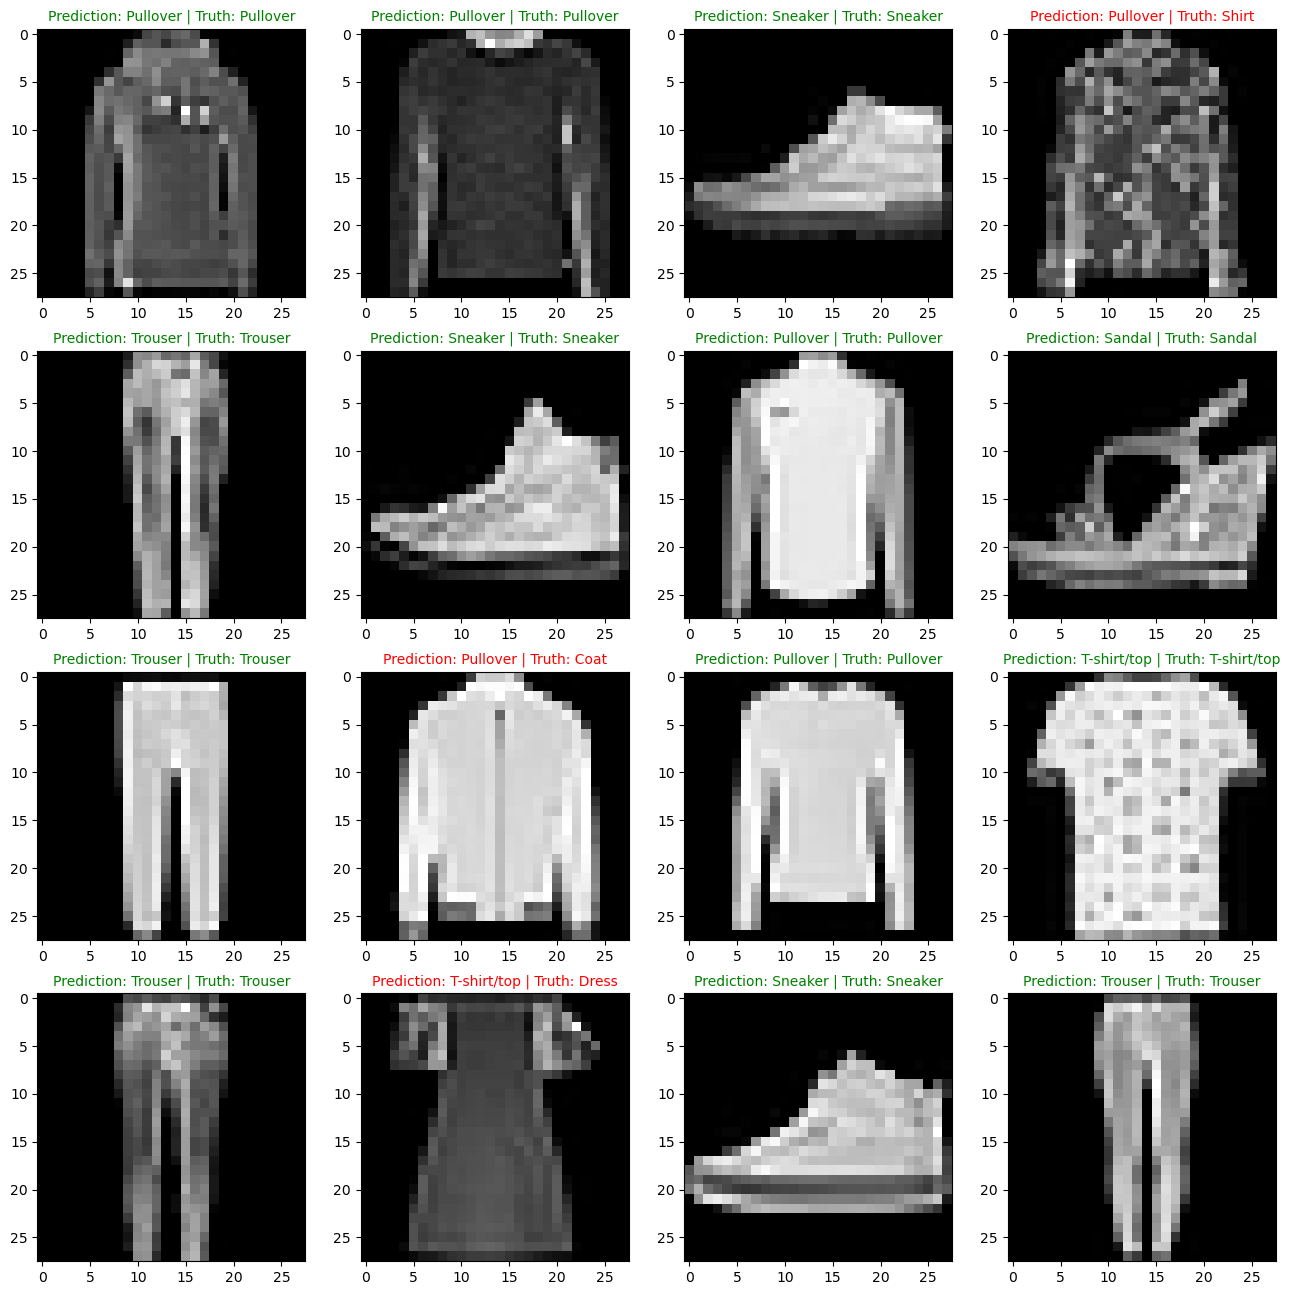

In [42]:
plt.figure(figsize=(16, 16))
rows = 4
cols = 4

for index, sample in enumerate(random_samples):
    plt.subplot(rows, cols, index+1)

    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = sample_predictions[index]

    truth_label = sample_labels[index]

    title_text = (f"Prediction: {pred_label} | Truth: {truth_label}")

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="green")
    else:
        plt.title(title_text, fontsize=10, c="red")

## The Save/Load

Basically the same code for Save and Load

In [ ]:
#Saving
from pathlib import Path


#Create directory
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

#Create saving path, usually pytorch files are called "pth"
model_name = "pytorch_classification_model_lv2.pth"
model_save_path = model_path / model_name

#Saving the state dict
print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=model_lv2.state_dict(),
           f=model_save_path)

In [ ]:
#Loading

#we'll need to create a new model and load the saved state_dict() into the new model
cooler_model = model_lv2()

#loading the saved state dict from the new model, with torch.load()
cooler_model.load_state_dict(torch.load(f=model_save_path))